# Introdução

Nesse projeto, vamos usar uma base de dados com avaliações de usuários sobre roupas femininas. Nosso objetivo aqui é, com base nas avaliações, prever se a review do usuário indica que ele recomendará o produto, assim como estimar a avaliação que ele dará.

# Importar bibliotecas necessárias

Nesse projeto, eu irei usar a biblioteca Spacy, para lemmetizar os comentários, ao invés de stemmetizar eles.

No código abaixo, irei realizar o download da biblioteca.

In [1]:
%%capture
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_trf

Vamos também atualizar o Sklearn

In [2]:
%%capture
!pip install --upgrade scikit-learn

In [3]:
import sklearn
sklearn.__version__

'1.6.1'

Iremos importar as bibliotecas necessárias

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Caso se queira ver os gráficos
import nltk # NLP
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # Stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
import re
from datetime import datetime
from tqdm import tqdm
import spacy


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Importar base de dados

Vamos importar a base de dados e dar uma olhada nela

In [5]:
dados = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")
dados.sample(n=5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
20931,20931,1009,66,Runs small,"I am so in love with this skirt, but unfortuna...",3,1,5,General,Bottoms,Skirts
20733,20733,883,36,NaN,NaN,4,1,0,General,Tops,Knits
16062,16062,1056,33,Bring back tall sizes!,"Retailer, please make these fantastically vers...",3,0,0,General,Bottoms,Pants
3023,3023,302,89,NaN,"Love the fabric, fits true to size, great qual...",5,1,0,Initmates,Intimate,Swim
2507,2507,1078,61,Enormous,I ordered a size 0. the dress was extremely la...,3,0,7,General Petite,Dresses,Dresses


Vamos agora dar uma olhada na descrição dos dados

In [6]:
dados.describe(include='all')

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
count,23486.000000,23486.000000,23486.000000,19676,22641,23486.000000,23486.000000,23486.000000,23472,23472,23472
unique,NaN,NaN,NaN,13993,22634,NaN,NaN,NaN,3,6,20
top,NaN,NaN,NaN,Love it!,Perfect fit and i've gotten so many compliment...,NaN,NaN,NaN,General,Tops,Dresses
freq,NaN,NaN,NaN,136,3,NaN,NaN,NaN,13850,10468,6319
mean,11742.500000,918.118709,43.198544,NaN,NaN,4.196032,0.822362,2.535936,NaN,NaN,NaN
std,6779.968547,203.298980,12.279544,NaN,NaN,1.110031,0.382216,5.702202,NaN,NaN,NaN
min,0.000000,0.000000,18.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,5871.250000,861.000000,34.000000,NaN,NaN,4.000000,1.000000,0.000000,NaN,NaN,NaN
50%,11742.500000,936.000000,41.000000,NaN,NaN,5.000000,1.000000,1.000000,NaN,NaN,NaN
75%,17613.750000,1078.000000,52.000000,NaN,NaN,5.000000,1.000000,3.000000,NaN,NaN,NaN


Podemos ver que a avaliação média dos usuários é de 4,20 de 5. 
Podemos ver também que houve mais de 23 mil avaliações, além disso, 82% dos usuários recomendam os produtos.

# Análise descritiva

Vamos dar uma olhada em alguns gráficos a fim de analisar nossa base de dados

Text(0.5, 1.0, 'Histograma das Reviews')

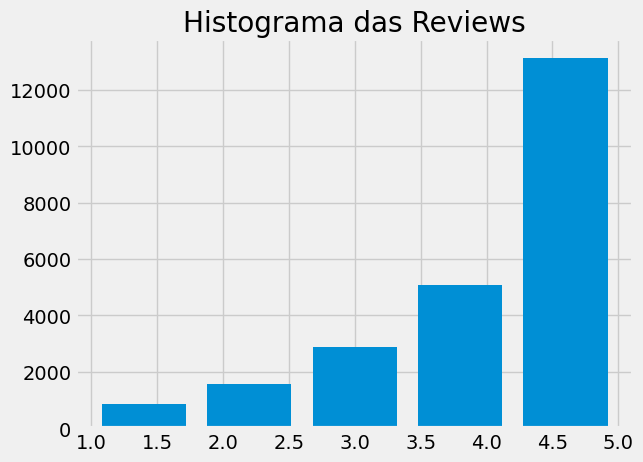

In [7]:
plt.style.use('fivethirtyeight')
plt.hist(dados['Rating'], 
         bins=5,
        rwidth=0.8)
plt.title("Histograma das Reviews")

Agora vamos observar as idades das consumidoras

Text(0.5, 1.0, 'Idades das consumidoras')

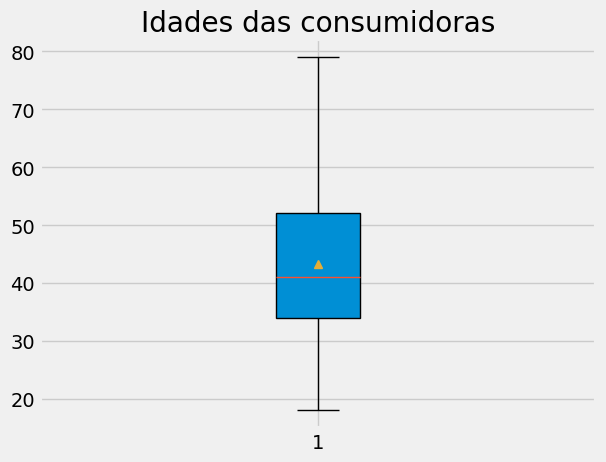

In [8]:
plt.boxplot(dados['Age'],
           patch_artist=True,
           showmeans=True,
            showfliers=False)
plt.title("Idades das consumidoras")

# Pré-Processamento dos Dados

Nessa etapa, vamos começar a preparar os dados para o modelo treinar e testar sua acurácia. Vamos utilizar no modelo, como variáveis independentes, o título e a descrição da avaliação. Para variável dependente será: se o usuário recomenda e a nota que ele deu ao produto

Primeiro, vamos criar a variável responsável pela lemmetização e ver um exemplo. 

[Aqui tem uma documentação completa do Spacy que será interessante você ler](https://spacy.io/usage/spacy-101)

[Assim como aqui tem um exemplo do seu uso](https://spacy.io/usage/spacy-101)

In [11]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("I'm Salomão, and this is my project.")
print([(w.text, w.pos_) for w in doc if  w.is_alpha])

[('I', 'PRON'), ('Salomão', 'PROPN'), ('and', 'CCONJ'), ('this', 'PRON'), ('is', 'AUX'), ('my', 'PRON'), ('project', 'NOUN')]


Nessa etapa, agora, iremos realizar um breve pré-processamento dos títulos e comentários. Um tratamento básico de dados a fim de pegar somente palavras

In [12]:
tqdm.pandas() # ver barra de progresso

reg=re.compile("[^A-zÀ-ú0-9]+") # Pré-compilar uma RegEx a fim de pegar somente palavras no texto

dados['tituloCorpus'] = dados['Title'].fillna(value="").progress_apply(lambda x: reg.sub(' ', x).lower())
dados['descCorpus'] = dados['Review Text'].fillna(value="").progress_apply(lambda x: reg.sub(' ', x).lower())



100%|██████████| 23486/23486 [00:00<00:00, 41917.14it/s]


Agora iniciaremos o processo de lemmetizar as avaliações e os títulos. 

Usaremos um pipeline a fim de acelerar o processo. Você pode ver a documentação [aqui](https://spacy.io/usage/processing-pipelines) para mais informações

In [13]:
desabilitar = ["parser", "ner", "tagger", "entity_linker", "entity_ruler", "textcat", "textcat_multilabel", "trainable_lemmatizer",
              "senter", "sentencizer", "transformer"] # Estas são as funcionalidades que iremos desabilitar, a fim de deixar o pipeline mais rápido
pipeTitulo = nlp.pipe(dados['tituloCorpus'], disable=desabilitar)
pipeReview = nlp.pipe(dados['descCorpus'], disable=desabilitar)

titulos = []
reviews = []


# for doc in tqdm(pipeTitulo, desc="Lemmatizando títulos"):
#     # Na linha abaixo, ele irá retornar o lemma de cada palavra
#     retorno = " ".join([token.lemma_ for token in doc if token.is_alpha])
#     titulos.append(retorno)

for doc in tqdm(pipeReview, desc="Lemmatizando Reviews"):
    # Na linha abaixo, ele irá retornar o lemma de cada palavra
    retorno = " ".join([token.lemma_ for token in doc if token.is_alpha])
    reviews.append(retorno)

np.random.choice(reviews, size=5)

Lemmatizando Reviews: 0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Lemmatizando Reviews: 23486it [01:17, 301.43it/s]


array(['not sure why it has gotten good ratings and or why sold out online periodically awkward fit and flares quit a bit at waist also has extra material at waist line so does not look flattering',
       'i bought this dress as a surprise for my daughter she was very happy with it',
       'this skirt has a beautiful flattering feminine fit the floral pattern is delicate and a little different and of course the layers are what make this piece a stunner i highly recommend it can see wearing this all year dressed up with jewels or down with boots and a casual sweater',
       'i am five foot tall about lb and got the petite zero it fits perfectly and i love the flower pattern great for weddings parties or work',
       'i just got this tank and love it it has the perfect amount of swing but does run a little large the underlay was more yellow than i expected but i think it adds a nice amount of brightness to the top this will be a summer staple'],
      dtype='<U500')

# Extração de X e Y e criação da matriz esparsa

Nessa etapa, vamos transformar os títulos e as descrições em matrizes esparsas utilizando TfidfVectorizer ([veja a documentação aqui ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) a fim de ponderar as palavras pela quantidade de vezes que elas aparecem.

Para Y, irei colocar apenas se o usuário recomendaria o produto com base no seu comentário. Eu até tentei colocar isso como uma relação da nota, mas não mostrou muita significância estatística.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.compose import make_column_transformer

maximoPalavras = 10_000

# tfidTitulo = TfidfVectorizer(max_features=maximoPalavras)
tfidDesc = TfidfVectorizer(max_features=maximoPalavras)

# xTitulo = tfidTitulo.fit_transform(titulos).toarray()
xDesc = tfidDesc.fit_transform(reviews).toarray()

# X = np.concatenate((xTitulo, xDesc), axis=1)
X = xDesc

Y = dados['Recommended IND'].values

Vamos dar uma olhada nas dimensões do X e do Y, eles devem ter o mesmo número de observações.

In [16]:
print(f"Dimensão X: {X.shape}")
print(f"Dimensão Y: {Y.shape}")

Dimensão X: (23486, 10000)
Dimensão Y: (23486,)


Vamos, agora, dividir a base de dados em treino e teste. [Veja a documentação aqui](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html.)

In [17]:
from sklearn.model_selection import train_test_split
xtreino, xteste, ytreino, yteste = train_test_split(X, Y, test_size = 0.2, random_state = 50)

# Escolha do modelo

Nessa etapa iremos escolher o melhor modelo. O Sklearn tem um mapa mental que nos ajudará a escolher o modelo mais adequado, [você pode ter acesso a ele clicando aqui](https://scikit-learn.org/1.3/tutorial/machine_learning_map/)

Utilizando ele, podemos ver que o modelo sugerido é o [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

In [18]:
from sklearn.svm import LinearSVC
clf = LinearSVC(max_iter = 500, tol = 5e-3)
clf.fit(xtreino, ytreino)

LinearSVC(max_iter=500, tol=0.005)

Agora vamos avaliar nosso modelo.

Como estamos usando um modelo de classificação, nosso foco será na acurácia.


Você pode avaliar as métricas de desempenho dos modelos [nesse link](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, root_mean_squared_error # Importar bibliotecas para análise do desempenho

predicao = clf.predict(xteste) # O modelo vai tentar prever a base de testes.
desvioPadrao = accuracy_score(yteste, predicao)*100
print(f'Acurácia do nosso modelo: {desvioPadrao:.2f}%')


Acurácia do nosso modelo: 88.85%


In [35]:
obsTeste = dados.sample(1)
comentario=obsTeste['descCorpus'].values

comentario = tfidDesc.transform(comentario)
previsao = "Recomendou" if clf.predict(comentario) == 1 else "Não recomendou"
recomendou = "Recomendou" if obsTeste['Recommended IND'].values[0] == 1 else "Não recomendou"
print(f"Comentário aleatório:\n\n{obsTeste['Review Text'].values[0]}\n\nPrevisão: {previsao}\nRealidade: {recomendou}")

Comentário aleatório:

I had different expectations for this shirt in blue and when i received the item it didn't met those expectations. the material is very good quality but there is nothing extraordinary about the shirt, it is jus very plain. this item is being returned.

Previsão: Não recomendou
Realidade: Não recomendou
